# Medical JComp

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [3]:
# !cp ./gdrive/MyDrive/CSE3042_JComp/images.zip ./
# !cp ./gdrive/MyDrive/CSE3042_JComp/uterus_segmentation.h5 ./
# !rm -rf images > /dev/null
!unzip ./images.zip > /dev/null

## Imports

In [19]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split
import cv2 as cv
from google.colab.patches import cv2_imshow    
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

## Load images

In [4]:
# Normal uterus
normal = sorted(glob.glob("./images/normal/original/*.jpg"))
normal_uterus = sorted(glob.glob("./images/normal/uterus_mask/*.jpg"))
normal_endomet = sorted(glob.glob("./images/normal/endometrium_mask/*.jpg"))
normal_fibroid = sorted(glob.glob("./images/normal/fibroid_mask/*.jpg"))

# Uterus with fibroids
fibroid = sorted(glob.glob("./images/fibroid/original/*.jpg"))
fibroid_uterus = sorted(glob.glob("./images/fibroid/uterus_mask/*.jpg"))
fibroid_fibroid = sorted(glob.glob("./images/fibroid/fibroid_mask/*.jpg"))

# Uterus with Adenomyosis
adeno = sorted(glob.glob("./images/adenomyosis/original/*.jpg"))
adeno_uterus = sorted(glob.glob("./images/adenomyosis/uterus_mask/*.jpg"))
adeno_endomet = sorted(glob.glob("./images/adenomyosis/endometrium_mask/*.jpg"))
adeno_fibroid = sorted(glob.glob("./images/adenomyosis/fibroid_mask/*.jpg"))

In [5]:
if len(normal) == len(normal_uterus) and len(normal) == len(normal_endomet) and len(normal) == len(normal_fibroid):
    print(f"Loaded {len(normal)} normal images")
else:
    print(f"Missing normal images {len(normal)=} {len(normal_uterus)=} {len(normal_endomet)=}")

if len(fibroid) == len(fibroid_fibroid) and len(fibroid) == len(fibroid_uterus) and len(fibroid) == len(fibroid_fibroid):
    print(f"Loaded {len(fibroid)} fibroid images")
else:
    print(f"Missing fibroid images {len(fibroid)=} {len(fibroid_fibroid)=} {len(fibroid_uterus)=}")

if len(adeno) == len(adeno_uterus) and len(adeno) == len(adeno_endomet) and len(adeno) == len(adeno_fibroid):
    print(f"Loaded {len(adeno)} fibroid images")
else:
    print(f"Missing fibroid images {len(adeno)=} {len(adeno_uterus)=} {len(adeno_endomet)=}")

Loaded 29 normal images
Loaded 44 fibroid images
Loaded 32 fibroid images


In [6]:
def load_image_from_path(img_path: str, grayscale = True):
    """
    Load a grayscale, resized and normalized image from given path
    """
    img = Image.open(img_path)
    if grayscale:
      img = img.convert("L")
    img = img.resize((512,512))
    img = np.array(img) / 255.0
    if grayscale:
      img = np.reshape(img, (512,512,1))    
    else:
      img = np.reshape(img, (512,512,3))    
    return img

def visualize_image_mask(image: np.ndarray, mask1 = None, mask2=None, mask3=None, image_title="Image", mask1_title="Mask 1", mask2_title="Mask 2",  mask3_title="Mask 3"):
    """
    Visualizes an image and its corresponding masks side-by-side.
    """
    cols = 2
    if mask2 is not None:
        cols = 3
    if mask3 is not None:
        cols = 4
    fig, ax = plt.subplots(1, cols, figsize=(cols*3, 5))
    ax[0].imshow(image, cmap="gray")
    ax[0].set_title(image_title)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    if mask1 is not None:
      ax[1].imshow(mask1, cmap="gray")
      ax[1].set_title(mask1_title)
      ax[1].set_xticks([])
      ax[1].set_yticks([])
    if mask2 is not None:
        ax[2].imshow(mask2, cmap="gray")
        ax[2].set_title(mask2_title)
        ax[2].set_xticks([])
        ax[2].set_yticks([])
    if mask3 is not None:
        ax[3].imshow(mask3, cmap="gray")
        ax[3].set_title(mask3_title)
        ax[3].set_xticks([])
        ax[3].set_yticks([])
    plt.show()

# Visualize some samples and masks

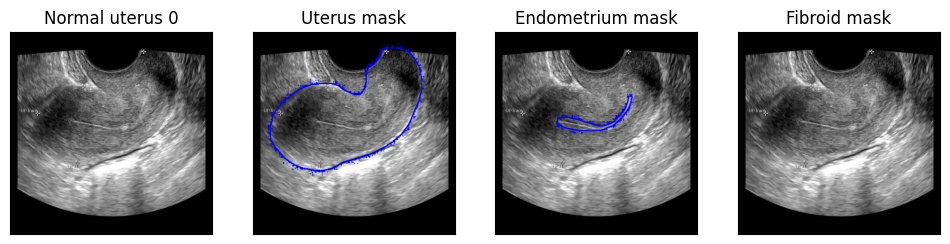

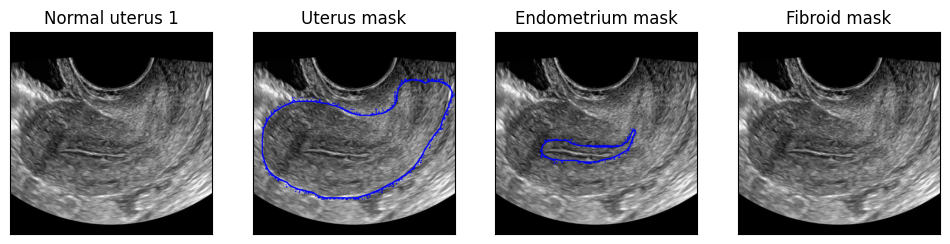

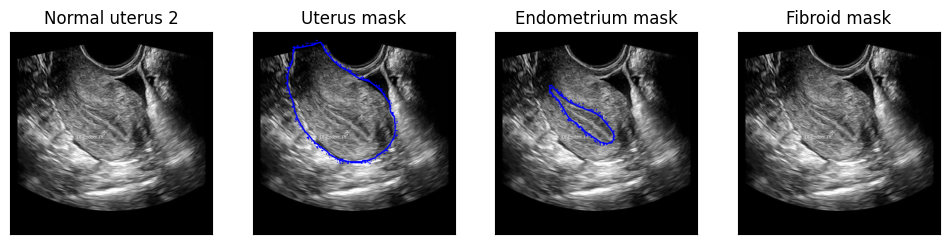

In [7]:
import cv2

def draw_mask_outline(original_image, mask):
    """
    Draws a blue outline on the original image around the masked region.
    """
    original_image = (original_image * 255).astype(np.uint8)
    mask = (mask*255).astype(np.uint8)

    original_image_rgb = original_image
    if original_image.shape[-1] == 1:
      original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_GRAY2RGB)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(original_image_rgb, contours, -1, (0, 0, 255), 2)

    return original_image_rgb

for i in range(3):
    img1 = load_image_from_path(normal[i])
    img1_uterus = load_image_from_path(normal_uterus[i])
    img1_endomet = load_image_from_path(normal_endomet[i])
    img1_fibroid = load_image_from_path(normal_fibroid[i])
    visualize_image_mask(img1, draw_mask_outline(img1, img1_uterus), draw_mask_outline(img1, img1_endomet), draw_mask_outline(img1, img1_fibroid), image_title=f"Normal uterus {i}", mask1_title="Uterus mask", mask2_title="Endometrium mask", mask3_title="Fibroid mask")

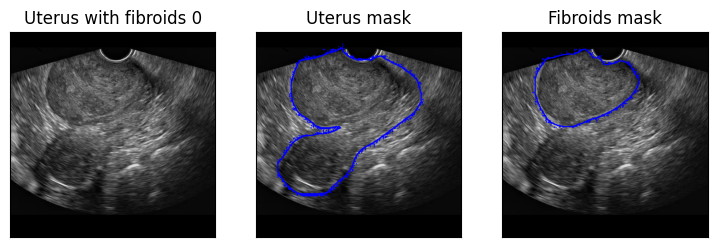

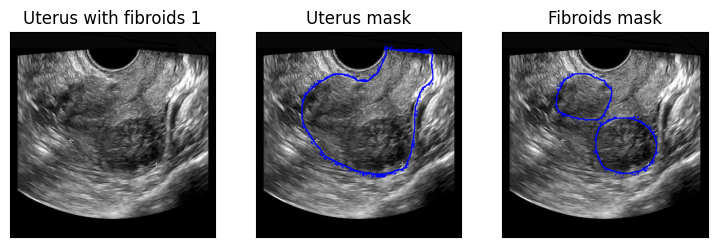

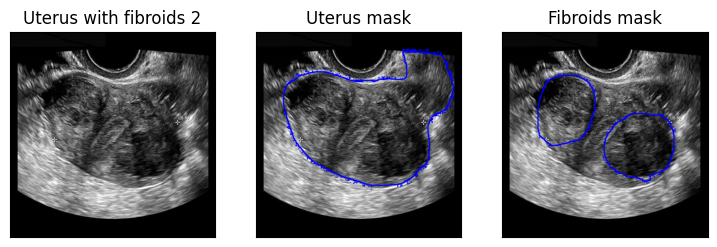

In [8]:
for i in range(3):
    img1 = load_image_from_path(fibroid[i])
    img1_uterus = load_image_from_path(fibroid_uterus[i])
    img1_fibroid = load_image_from_path(fibroid_fibroid[i])
    visualize_image_mask(img1, draw_mask_outline(img1, img1_uterus), draw_mask_outline(img1, img1_fibroid), image_title=f"Uterus with fibroids {i}", mask1_title="Uterus mask", mask2_title="Fibroids mask")

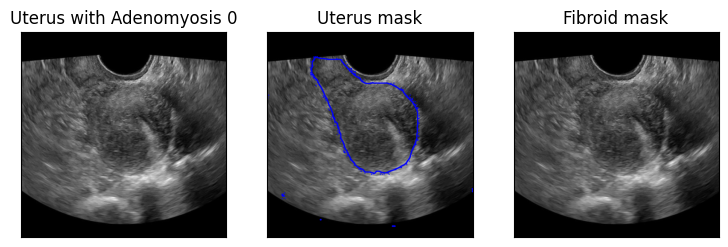

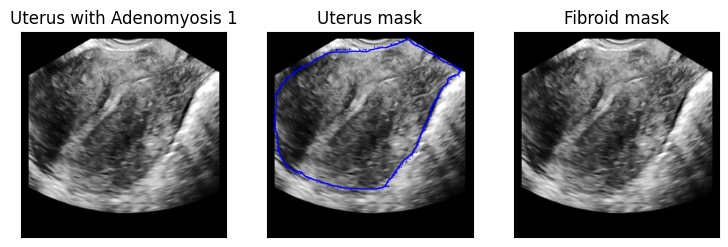

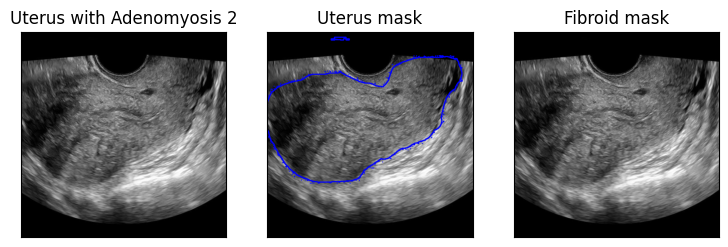

In [9]:
for i in range(3):
    img1 = load_image_from_path(adeno[i])
    img1_uterus = load_image_from_path(adeno_uterus[i])
    img1_fibroid = load_image_from_path(adeno_fibroid[i])
    visualize_image_mask(img1, draw_mask_outline(img1, img1_uterus), draw_mask_outline(img1, img1_fibroid), image_title=f"Uterus with Adenomyosis {i}", mask1_title="Uterus mask", mask2_title="Fibroid mask")

## Mask the uterus in images
Using the identified Uterus as an object in images directly, with the assumption of Doctor will segment out the Uterus or UNet model in the future will segment out the Uterus.

In [10]:
def generate_masked_images(img_filepaths, mask_filepaths):
  imgs = []
  for path in img_filepaths:
    imgs.append(load_image_from_path(path, False))
  imgs = np.array(imgs)

  masks = []
  for path in mask_filepaths:
    masks.append(load_image_from_path(path))
  masks = np.array(masks)

  return np.multiply(imgs, masks)

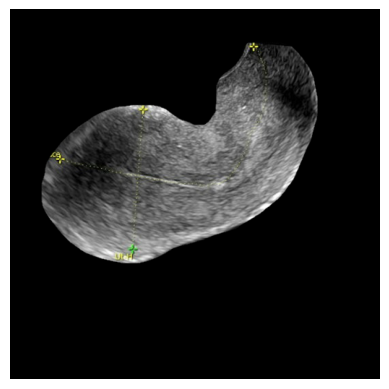

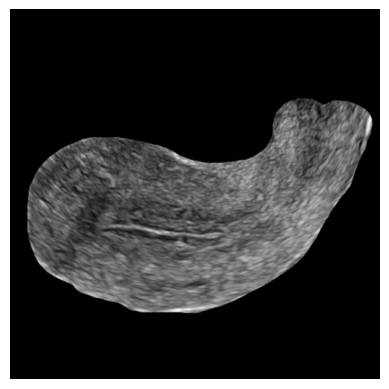

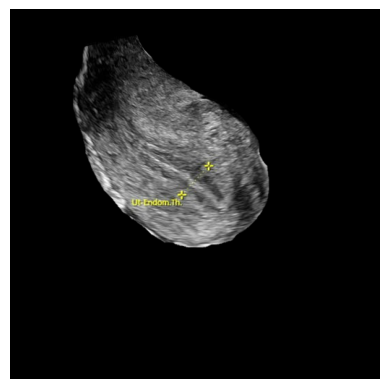

In [11]:
# Normal uterus masked
masked_normal_imgs = generate_masked_images(normal, normal_uterus)
for i in range(3):
    img1 = masked_normal_imgs[i]
    plt.imshow(img1, cmap="gray")
    plt.axis('off')
    plt.show()

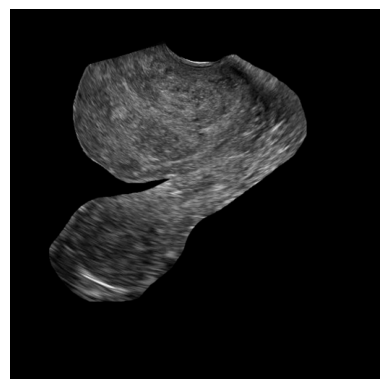

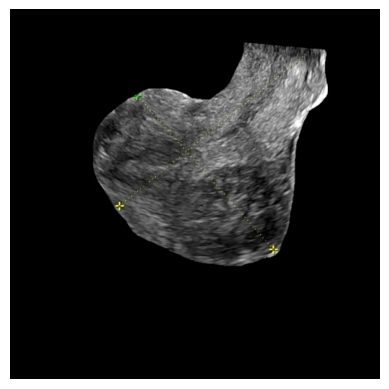

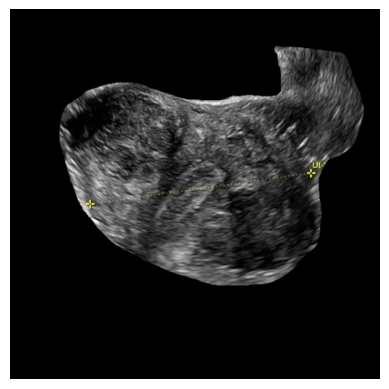

In [12]:
# Uterus with fibroid masked
masked_fibroid_imgs = generate_masked_images(fibroid, fibroid_uterus)
for i in range(3):
    img1 = masked_fibroid_imgs[i]
    plt.imshow(img1, cmap="gray")
    plt.axis('off')
    plt.show()

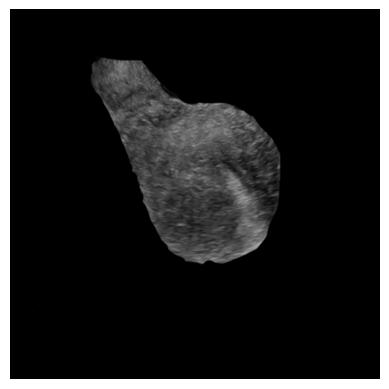

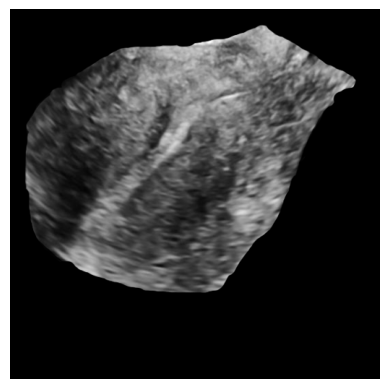

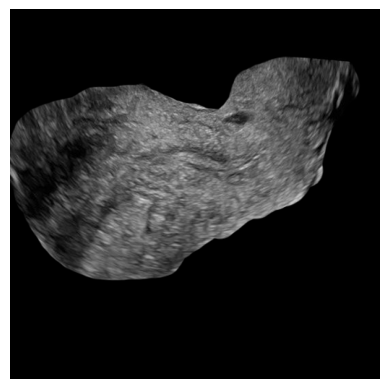

In [13]:
# Uterus with Adenomyosis masked
masked_adeno_imgs = generate_masked_images(adeno, adeno_uterus)
for i in range(3):
    img1 = masked_adeno_imgs[i]
    plt.imshow(img1, cmap="gray")
    plt.axis('off')
    plt.show()

## Fibroid detection model

In [57]:
from keras.callbacks import Callback

class StopTrainingOnValAccuracy(Callback):
    def __init__(self, target_val_accuracy):
        super(StopTrainingOnValAccuracy, self).__init__()
        self.target_val_accuracy = target_val_accuracy

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs['val_accuracy']
        if val_accuracy >= self.target_val_accuracy:
            print(f'Reached plateau in training... Stopped training.')
            self.model.stop_training = True

In [58]:
X = np.concatenate((masked_normal_imgs, masked_fibroid_imgs, masked_adeno_imgs), axis=0)
y = np.concatenate((np.zeros(masked_normal_imgs.shape[0]), np.ones(masked_fibroid_imgs.shape[0]), np.zeros(masked_adeno_imgs.shape[0])), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
X_train.shape, X_test.shape

((84, 512, 512, 3), (21, 512, 512, 3))

In [60]:
IMAGE_SHAPE = (512,512,3)

vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=IMAGE_SHAPE)
vgg16.trainable = False

fibroid_model = models.Sequential([
    vgg16,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

fibroid_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

In [61]:
fibroid_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 16, 16, 512)       14714688  
                                                                 
 global_average_pooling2d_7   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_14 (Dropout)        (None, 512)               0         
                                                                 
 dense_21 (Dense)            (None, 1024)              525312    
                                                                 
 dropout_15 (Dropout)        (None, 1024)              0         
                                                                 
 dense_22 (Dense)            (None, 128)               131200    
                                                      

In [64]:
history = fibroid_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16)

Epoch 1/50
6/6 [==============================] - 2s 378ms/step - loss: 0.5775 - accuracy: 0.7024 - val_loss: 0.5593 - val_accuracy: 0.7619
Epoch 2/50
6/6 [==============================] - 2s 393ms/step - loss: 0.5699 - accuracy: 0.7143 - val_loss: 0.5450 - val_accuracy: 0.7619
Epoch 3/50
6/6 [==============================] - 2s 344ms/step - loss: 0.5216 - accuracy: 0.7857 - val_loss: 0.5276 - val_accuracy: 0.7619
Epoch 4/50
6/6 [==============================] - 2s 385ms/step - loss: 0.5846 - accuracy: 0.6786 - val_loss: 0.5160 - val_accuracy: 0.7619
Epoch 5/50
6/6 [==============================] - 2s 347ms/step - loss: 0.6525 - accuracy: 0.6786 - val_loss: 0.5446 - val_accuracy: 0.8095
Epoch 6/50
6/6 [==============================] - 2s 390ms/step - loss: 0.6717 - accuracy: 0.5833 - val_loss: 0.5136 - val_accuracy: 0.7619
Epoch 7/50
6/6 [==============================] - 2s 385ms/step - loss: 0.5926 - accuracy: 0.7143 - val_loss: 0.5176 - val_accuracy: 0.7619
Epoch 8/50
6/6 [====

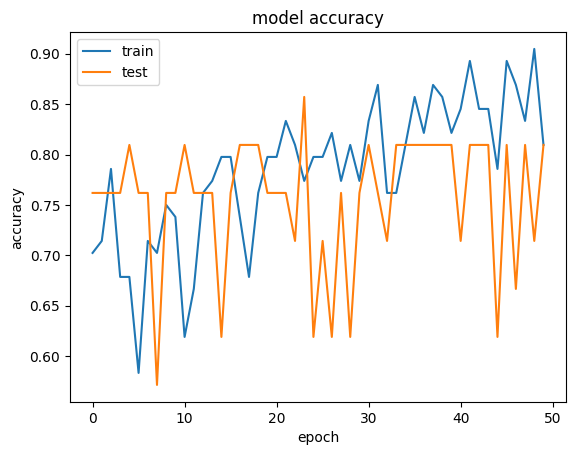

In [65]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [66]:
results = fibroid_model.evaluate(X_test, y_test)

1/1 [==============================] - 1s 615ms/step - loss: 0.4451 - accuracy: 0.8095


## Fibroid detection with preprocess pipeline

In [67]:
def brightness_contrast(img, brightness=255, contrast=127):
    brightness = int((brightness - 0) * (255 - (-255)) / (510 - 0) + (-255))
    contrast = int((contrast - 0) * (127 - (-127)) / (254 - 0) + (-127))
  
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            max = 255
        else:
            shadow = 0
            max = 255 + brightness
        al_pha = (max - shadow) / 255
        ga_mma = shadow
        cal = cv.addWeighted(img, al_pha, img, 0, ga_mma)
    else:
        cal = img
  
    if contrast != 0:
        Alpha = float(131 * (contrast + 127)) / (127 * (131 - contrast))
        Gamma = 127 * (1 - Alpha)
        cal = cv.addWeighted(cal, Alpha, cal, 0, Gamma)
    return cal

In [68]:
def fibroid_model_preprocess(image, blur_size=11):
  ret = cv.GaussianBlur(image, (blur_size, blur_size), 0)
  ret = brightness_contrast(ret, brightness=360, contrast=220)
  ret = brightness_contrast(ret, brightness=250, contrast=150)
  ret = cv.GaussianBlur(ret, (5, 5), 0)
  return ret

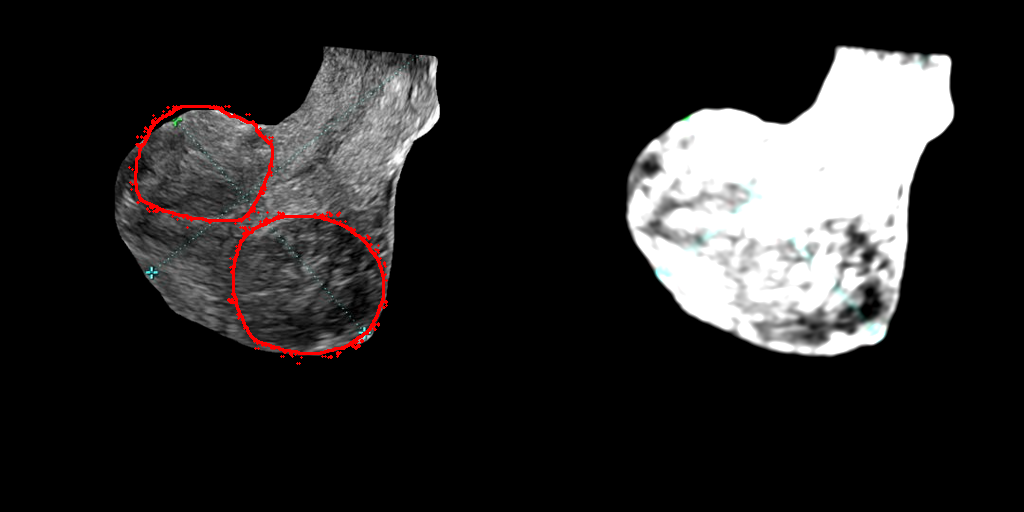

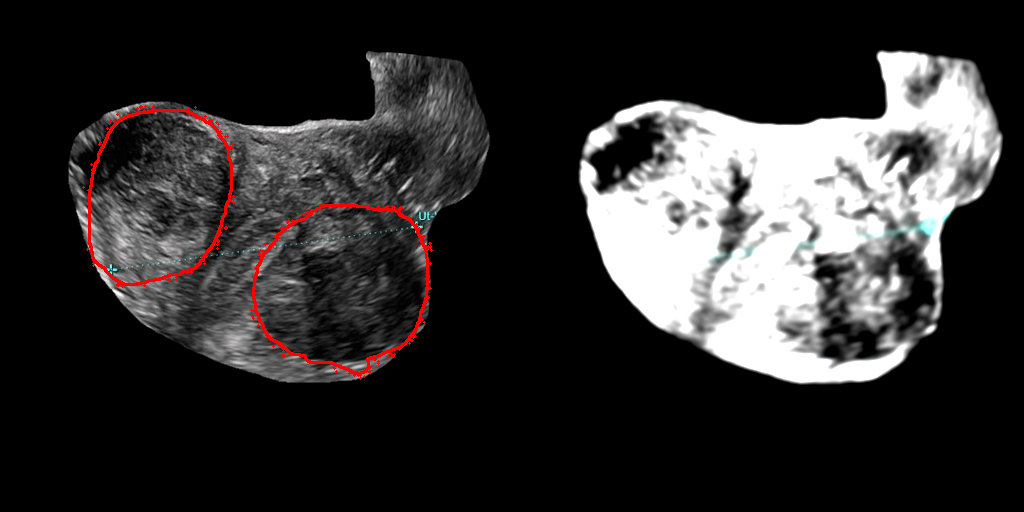

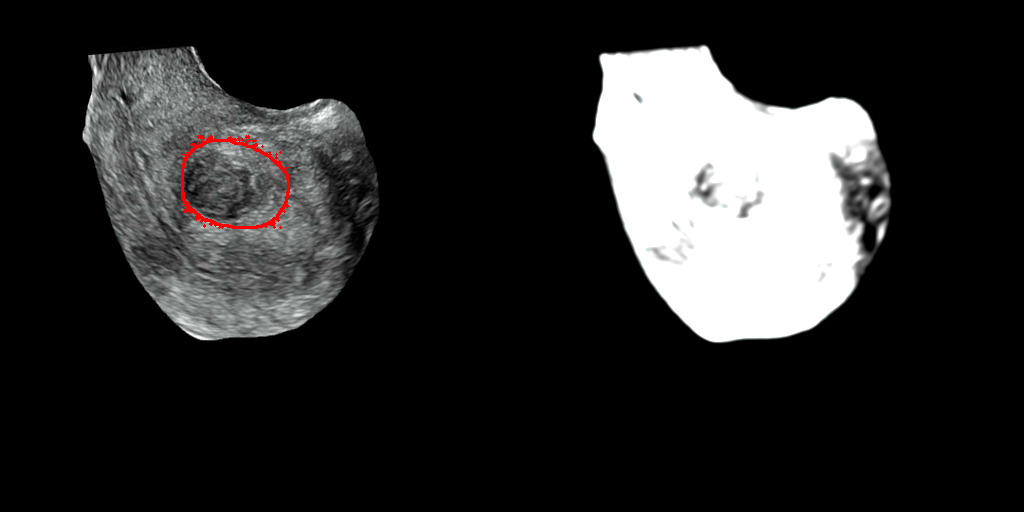

In [69]:
fibroid_fibroid_masks = []
for path in fibroid_fibroid:
  fibroid_fibroid_masks.append(load_image_from_path(path))
fibroid_fibroid_masks = np.array(fibroid_fibroid_masks)

for i in range(1,4):
  img = masked_fibroid_imgs[i]
  mask = fibroid_fibroid_masks[i]
  preprocessed = fibroid_model_preprocess(img*255.0) / 255.0

  both = cv.hconcat((draw_mask_outline(img, mask)*1.0, preprocessed*255.0))
  cv2_imshow(both)

In [75]:
X_train_preprocess = np.empty_like(X)

for i in range(X.shape[0]):
    X_train_preprocess[i] = fibroid_model_preprocess(X[i])
X_test_preprocess = np.empty_like(X_test)
for i in range(X_test.shape[0]):
    X_test_preprocess[i] = fibroid_model_preprocess(X_test[i])

In [73]:
X_train_preprocess.shape, X_test_preprocess.shape

((105, 512, 512, 3), (21, 512, 512, 3))

In [76]:
es = StopTrainingOnValAccuracy(0.95)
history = fibroid_model.fit(X_train_preprocess, y_train, validation_data=(X_test_preprocess, y_test), epochs=50, batch_size=16, callbacks=[es])

Epoch 1/50
7/7 [==============================] - 3s 381ms/step - loss: 1.8110 - accuracy: 0.5238 - val_loss: 1.2190 - val_accuracy: 0.6190
Epoch 2/50
7/7 [==============================] - 2s 346ms/step - loss: 0.8792 - accuracy: 0.5524 - val_loss: 0.6912 - val_accuracy: 0.4286
Epoch 3/50
7/7 [==============================] - 2s 352ms/step - loss: 0.6769 - accuracy: 0.6381 - val_loss: 0.6533 - val_accuracy: 0.6667
Epoch 4/50
7/7 [==============================] - 3s 386ms/step - loss: 0.6644 - accuracy: 0.6095 - val_loss: 0.6287 - val_accuracy: 0.6190
Epoch 5/50
7/7 [==============================] - 3s 381ms/step - loss: 0.6805 - accuracy: 0.5810 - val_loss: 0.6138 - val_accuracy: 0.7619
Epoch 6/50
7/7 [==============================] - 3s 383ms/step - loss: 0.6850 - accuracy: 0.5810 - val_loss: 0.6134 - val_accuracy: 0.6190
Epoch 7/50
7/7 [==============================] - 3s 384ms/step - loss: 0.6136 - accuracy: 0.6762 - val_loss: 0.5987 - val_accuracy: 0.8095
Epoch 8/50
7/7 [====

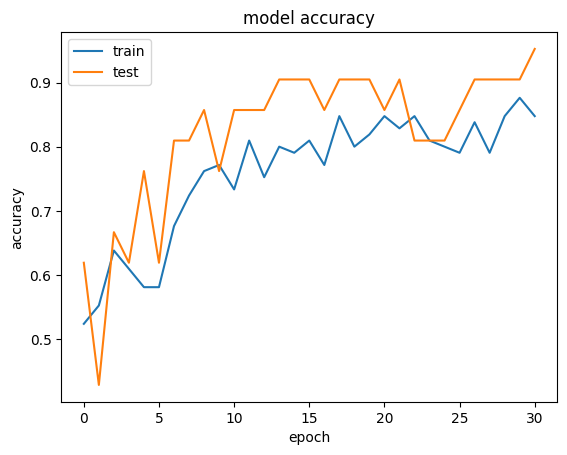

In [77]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [78]:
results = fibroid_model.evaluate(X_test_preprocess, y_test)

1/1 [==============================] - 1s 635ms/step - loss: 0.2619 - accuracy: 0.9524


## Endometrium detection model

In [79]:
X_endomet = np.concatenate((masked_normal_imgs, masked_fibroid_imgs, masked_adeno_imgs), axis=0)
y_endomet = np.concatenate((np.ones(masked_normal_imgs.shape[0]), np.zeros(masked_fibroid_imgs.shape[0]), np.zeros(masked_adeno_imgs.shape[0])), axis=0)

X_train_endomet, X_test_endomet, y_train_endomet, y_test_endomet = train_test_split(X_endomet, y_endomet, test_size=0.2, random_state=42)

In [80]:
vgg16_endomet = VGG16(weights="imagenet", include_top=False, input_shape=IMAGE_SHAPE)
vgg16_endomet.trainable = False

endomet_model = models.Sequential([
    vgg16_endomet,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

endomet_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

In [81]:
endomet_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 16, 16, 512)       14714688  
                                                                 
 global_average_pooling2d_8   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_16 (Dropout)        (None, 512)               0         
                                                                 
 dense_24 (Dense)            (None, 1024)              525312    
                                                                 
 dropout_17 (Dropout)        (None, 1024)              0         
                                                                 
 dense_25 (Dense)            (None, 128)               131200    
                                                      

In [82]:
history = endomet_model.fit(X_train_endomet, y_train_endomet, validation_data=(X_test_endomet, y_test_endomet), epochs=50, batch_size=16, callbacks=[es])

Epoch 1/50
7/7 [==============================] - 5s 469ms/step - loss: 0.6346 - accuracy: 0.6571 - val_loss: 0.7135 - val_accuracy: 0.7143
Epoch 2/50
7/7 [==============================] - 3s 380ms/step - loss: 0.6454 - accuracy: 0.7238 - val_loss: 0.6080 - val_accuracy: 0.7143
Epoch 3/50
7/7 [==============================] - 2s 348ms/step - loss: 0.5860 - accuracy: 0.7238 - val_loss: 0.5618 - val_accuracy: 0.7143
Epoch 4/50
7/7 [==============================] - 3s 385ms/step - loss: 0.6044 - accuracy: 0.7143 - val_loss: 0.5498 - val_accuracy: 0.7143
Epoch 5/50
7/7 [==============================] - 2s 352ms/step - loss: 0.5678 - accuracy: 0.7238 - val_loss: 0.5450 - val_accuracy: 0.7143
Epoch 6/50
7/7 [==============================] - 3s 372ms/step - loss: 0.5712 - accuracy: 0.7238 - val_loss: 0.5296 - val_accuracy: 0.7143
Epoch 7/50
7/7 [==============================] - 2s 361ms/step - loss: 0.5456 - accuracy: 0.7238 - val_loss: 0.5185 - val_accuracy: 0.7143
Epoch 8/50
7/7 [====

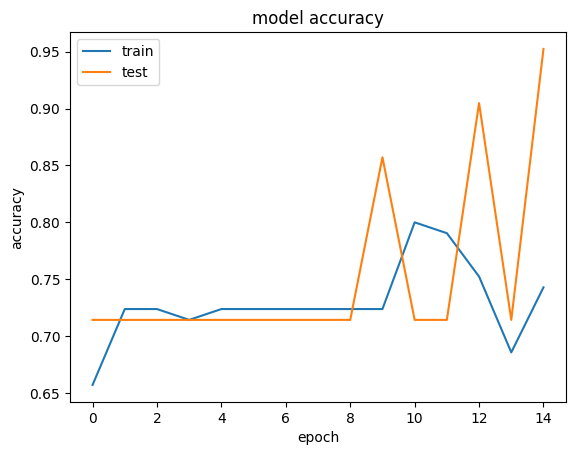

In [83]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [84]:
results = endomet_model.evaluate(X_test_endomet, y_test_endomet)

1/1 [==============================] - 1s 609ms/step - loss: 0.4580 - accuracy: 0.9524


## Prediction pipeline

In [116]:
NORMAL = 0
FIBROID = 1
ADENOMYOSIS = 2

def predict(image, fibroid_thres=0.85, endomet_thres=0.65):
  preprocessed = fibroid_model_preprocess(image)
  fibroid_percent = fibroid_model.predict(np.expand_dims(preprocessed, axis=0))[0][0]  

  if fibroid_percent >= fibroid_thres:
    return FIBROID
  
  endomet_percent = endomet_model.predict(np.expand_dims(image, axis=0))[0][0]
  if endomet_percent >= endomet_thres:
    return NORMAL
  
  return ADENOMYOSIS

def get_class(num):
  if num == NORMAL:
    return "NORMAL"
  if num == FIBROID:
    return "FIBROID"
  return "ADENOMYOSIS"

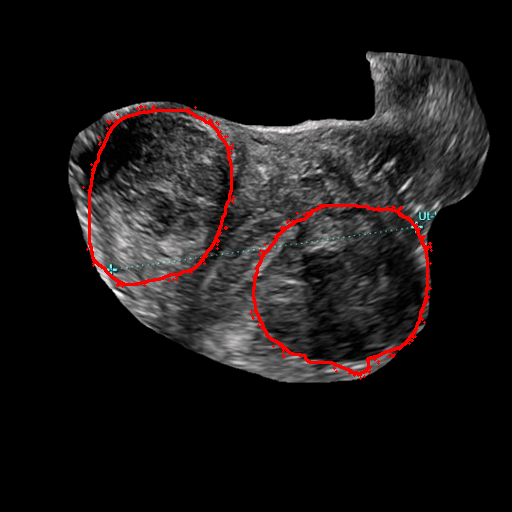

1/1 [==============================] - 0s 21ms/step
Class=FIBROID Correctly detected=True


In [117]:
img = masked_fibroid_imgs[2]
mask = fibroid_fibroid_masks[2]
cv2_imshow(draw_mask_outline(img, mask)*1.0)
ret = predict(img)
print(f"Class={get_class(ret)} Correctly detected={ret==FIBROID}")

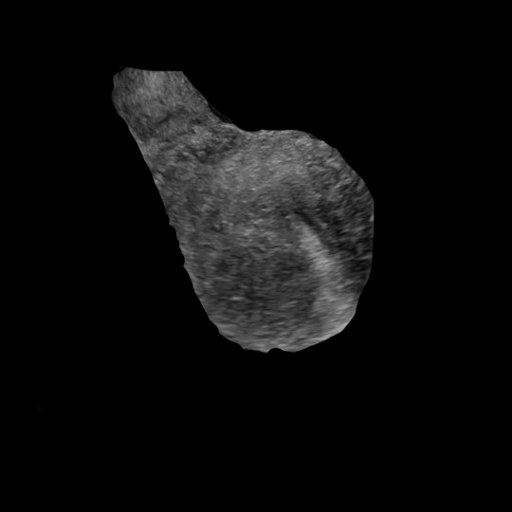

1/1 [==============================] - 0s 19ms/step
Class=ADENOMYOSIS Correctly detected=True


In [118]:
img = masked_adeno_imgs[0]
cv2_imshow(img*255.0)
ret = predict(img)
print(f"Class={get_class(ret)} Correctly detected={ret==ADENOMYOSIS}")

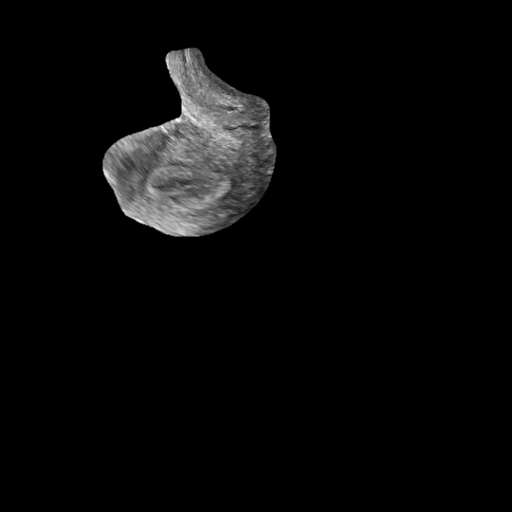

1/1 [==============================] - 0s 27ms/step
Class=NORMAL Correctly detected=True


In [121]:
img = masked_normal_imgs[3]
cv2_imshow(img*255.0)
ret = predict(img)
print(f"Class={get_class(ret)} Correctly detected={ret==NORMAL}")